In [1]:

from huggingface_hub import login
from dotenv import load_dotenv
import os


load_dotenv()  # Load environment variables from .env file


hf_token = os.getenv("HF_TOKEN")

login(token=hf_token)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:

# Get Noto JP font to display janapese characters
# !apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [50]:
from PIL import Image, ImageDraw, ImageFont
import ast
import numpy as np
import re
from IPython.display import display


def parse_json(bounding_boxes,caption):
    # Handles both literal JSON-style strings and simple float arrays
    if isinstance(bounding_boxes, str):
        # Detect float array style: '[num num num num]'
        float_array_match = re.findall(r"[-+]?\d*\.\d+|\d+", bounding_boxes)
        if float_array_match and len(float_array_match) == 4:
            # Convert to float, reshape and wrap in dict with dummy label
            coords = list(map(float, float_array_match))
            return [{"bbox_2d": coords, "label": caption}]
        else:
            try:
                return ast.literal_eval(bounding_boxes)
            except Exception as e:
                end_idx = bounding_boxes.rfind('"}') + len('"}')
                truncated_text = bounding_boxes[:end_idx] + "]"
                return ast.literal_eval(truncated_text)
    return bounding_boxes

def plot_bounding_boxes(im, bounding_boxes, caption, input_width, input_height):
    from PIL import ImageDraw, ImageFont

    img = im
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Define colors
    colors = [
        'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown',
        'gray', 'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy',
        'maroon', 'teal', 'olive', 'coral', 'lavender', 'violet', 'gold',
        'silver'
    ]

    try:
        font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)
    except OSError:
        # print("Font not found. Falling back to default.")
        font = ImageFont.load_default()

    parsed_boxes = parse_json(bounding_boxes,caption)
    # print(parsed_boxes)

    for i, bounding_box in enumerate(parsed_boxes):
        color = colors[i % len(colors)]

        y1, x1, y2, x2 = bounding_box["bbox_2d"]
        abs_y1 = int(y1 / input_height * height)
        abs_x1 = int(x1 / input_width * width)
        abs_y2 = int(y2 / input_height * height)
        abs_x2 = int(x2 / input_width * width)


        # abs_y1 = y1
        # abs_x1 = x1
        # abs_y2 = y2
        # abs_x2 = x2


        # Ensure proper ordering
        abs_x1, abs_x2 = sorted([abs_x1, abs_x2])
        abs_y1, abs_y2 = sorted([abs_y1, abs_y2])

        draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)

        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Uncomment to display
    display(img)


In [8]:
import os
import io
import pandas as pd
from PIL import Image as Image_PIL
import shutil
from datasets import load_dataset, Dataset, Image
from tqdm import tqdm
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file


# --- Configuration ---

hf_token = os.getenv("HF_TOKEN")

hf_user = "Rajarshi-Roy-research"
# dataset_name = "Flickr30k_Grounding_Som"
# commit_message = "Updating dataset with image paths"
# img_cols = ["image","wbox_image"]
# image_to_process = "image"

dataset_name = "refcocog-eval-depth"
commit_message = "Updating dataset with images and depth caption"
img_cols = ["image"]
image_to_process = "image"

# --- Helper Functions ---
def save_image_from_bytes(image_data, idx, image_folder):
    """Saves an image from byte data and returns the saved file path."""
    try:
        image_bytes = image_data.get("bytes", None)
        if image_bytes:
            image = Image_PIL.open(io.BytesIO(image_bytes))
            image_path = os.path.join(image_folder, f"image_{idx}.jpg")
            image.save(image_path, format="JPEG")
            print(f"✅ Saved: {image_path}")
            return image_path
        else:
            print(f"⚠️ Skipped row {idx}: No bytes found")
            return None
    except Exception as e:
        print(f"❌ Error saving image at row {idx}: {e}")
        return None


# --- Main Script ---
# Clean up existing image folder
for img_col in img_cols:
    if os.path.exists(img_col):
        shutil.rmtree(img_col)
    os.makedirs(img_col)

# Load dataset
ds = load_dataset(f"{hf_user}/{dataset_name}")
df = ds["train"].to_pandas()

for img_col in img_cols:
    # Save images and update DataFrame
    for i, row in df.iterrows():
        if isinstance(row[img_col], dict):
            df.at[i, img_col] = save_image_from_bytes(row[img_col], i, img_col)



✅ Saved: image\image_0.jpg
✅ Saved: image\image_1.jpg
✅ Saved: image\image_2.jpg
✅ Saved: image\image_3.jpg
✅ Saved: image\image_4.jpg
✅ Saved: image\image_5.jpg
✅ Saved: image\image_6.jpg
✅ Saved: image\image_7.jpg
✅ Saved: image\image_8.jpg
✅ Saved: image\image_9.jpg
✅ Saved: image\image_10.jpg
✅ Saved: image\image_11.jpg
✅ Saved: image\image_12.jpg
✅ Saved: image\image_13.jpg
✅ Saved: image\image_14.jpg
✅ Saved: image\image_15.jpg
✅ Saved: image\image_16.jpg
✅ Saved: image\image_17.jpg
✅ Saved: image\image_18.jpg
✅ Saved: image\image_19.jpg
✅ Saved: image\image_20.jpg
✅ Saved: image\image_21.jpg
✅ Saved: image\image_22.jpg
✅ Saved: image\image_23.jpg
✅ Saved: image\image_24.jpg
✅ Saved: image\image_25.jpg
✅ Saved: image\image_26.jpg
✅ Saved: image\image_27.jpg
✅ Saved: image\image_28.jpg
✅ Saved: image\image_29.jpg
✅ Saved: image\image_30.jpg
✅ Saved: image\image_31.jpg
✅ Saved: image\image_32.jpg
✅ Saved: image\image_33.jpg
✅ Saved: image\image_34.jpg
✅ Saved: image\image_35.jpg
✅ 



1. Prompt:A pair of tortillas containing a visible filling are positioned next to a heap of rice on a round plate.


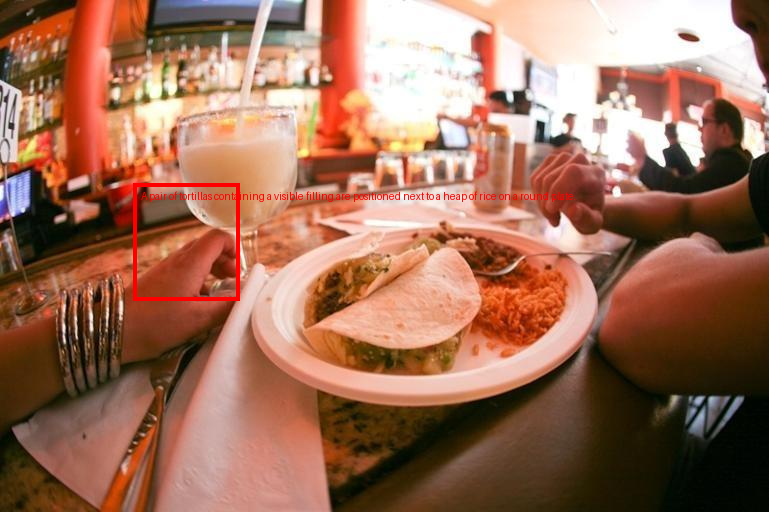



2. Prompt:The closed-top, white bucket-shaped item, positioned among numerous cooking tools and food receptacles at the street food stand.


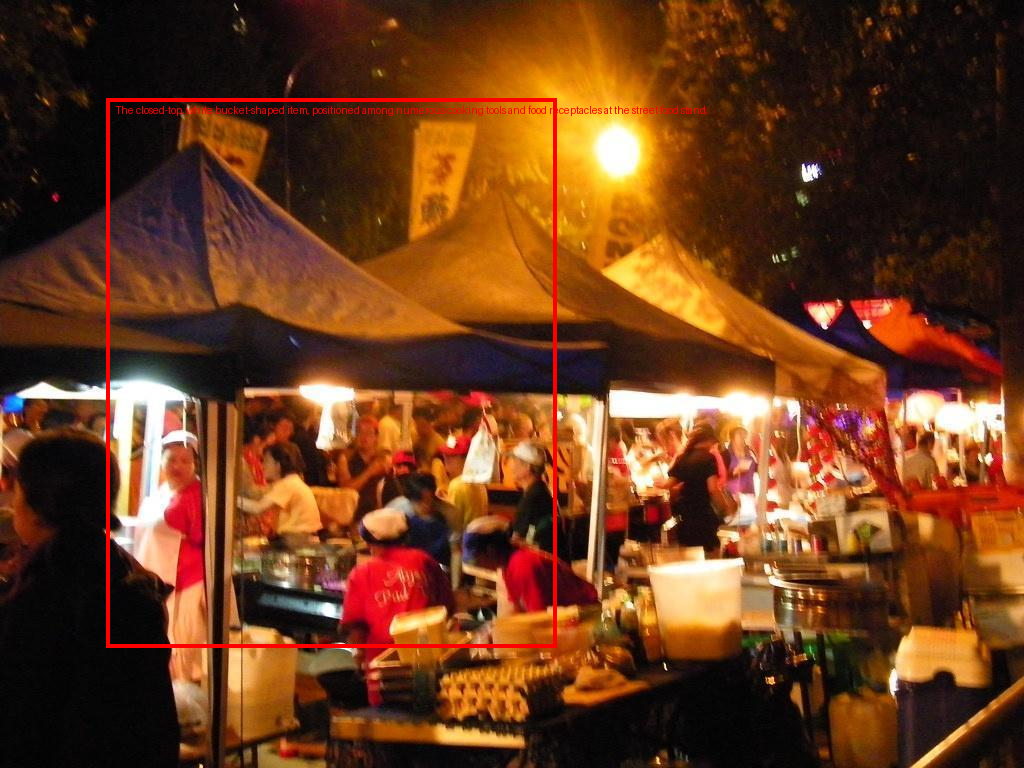



3. Prompt:The pink and white surfboard is curretnly riden by a man wearing a blue shirt.


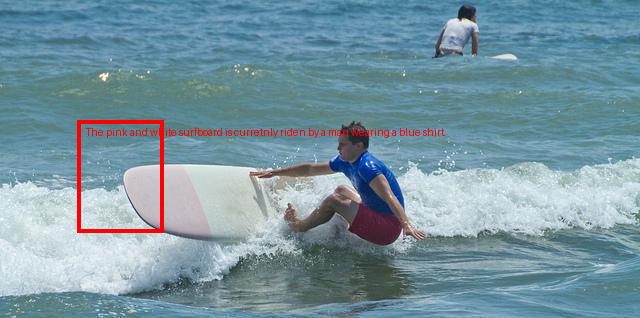



4. Prompt:The man wearing a cheerful Santa hat, characterized by its red color and white trim with a pom-pom, is depicted in the midst of a conversation, with his mouth partially open as though he is talking or preparing to talk.


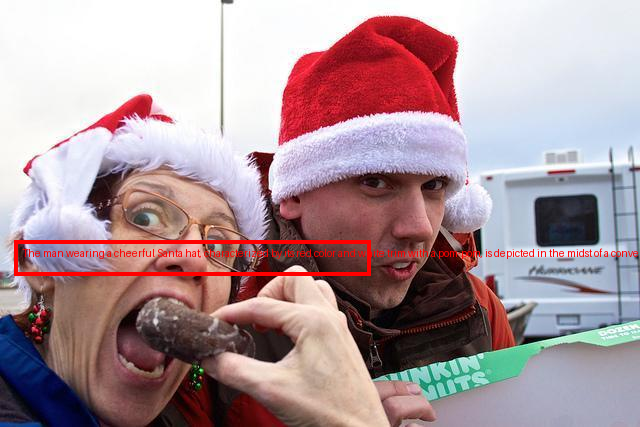

In [53]:

for idx in range(4):
    image_path = df["image"][idx]
    response = df["bbox"][idx]

    input_width = df["width"][idx]
    input_height = df["height"][idx]
    
    caption = df["caption"][idx]


    image = Image_PIL.open(image_path)
    print(f"\n\n{idx+1}. Prompt:{caption}")
    plot_bounding_boxes(image,response,caption,input_width,input_height)
